In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Latex


In [2]:
# sigularities
def sing(x,a,n):
    if not isinstance(x, np.ndarray):
        x = np.array([x])
    ni = np.zeros(x.size)
    for i in range(x.size):
        if x[i] >=a and n>=0:
            ni[i] = (x[i]-a)**n
    return ni/np.math.factorial(n)

def lx(ord_f,pc, tire_l, case,ab):
    p1,p2 = pp(tire_l,case,ab)
    react_f = GVWR*((1-pc)*sing(dx,0,ord_f)+pc/2*(sing(dx,lw1,ord_f)+sing(dx, lw2, ord_f)))
    other_f = p1*sing(dx,ab,ord_f)+p2*sing(dx,lc,ord_f)+W_tip/base_len*(sing(dx,0, ord_f+1)-sing(dx,base_len, ord_f+1))
    if case == 1:
        return react_f - other_f - Rc*sing(dx, tire_l, ord_f)
    else:
        return react_f - other_f

def pp(tire_l,load_fac,ab):
    react_f = Rc*((tire_l-a2)*load_fac+wheel_base)+W_tip*(G_tip-a2)
    p2 = react_f/(lc-a2)
    p1 = load_fac * Rc + W_tip - p2
    return p1,p2

def trail(ord_f,pc,tire_len, case=2):
    p1,p2 = pp(tire_len,case)
    react_f = p1*sing(dx,a2,ord_f)+p2*sing(dx,lc,ord_f)-W_tip/tip_len*(sing(dx,a1, ord_f+1)-sing(dx,a1+tip_len, ord_f+1))#todo sigularity(a), mom = @sig(a,1,2)
    if case == 1:
        rc_f = Rc*sing(dx,tire_len,ord_f)
    else:
        rc_f = Rc*(sing(dx,tire_len+wheel_base,ord_f)+sing(dx,tire_len,ord_f))
    return react_f - rc_f

note case on full front, case on half front,

case on back



In [3]:
len_full = 300

# predefined arrays
dx = np.linspace(-1,len_full, 200)
cat_tire_l_arr = np.arange(60,len_full-50,10)


In [4]:

def run_f(perc=None):
    max_p = [[0,0]]
    react_mat = []

    max_ptip = [[0,0]]
    react_mattip = []
    # loop through locations
    #const
    const_v = Rc*wheel_base+W_tip*(G_tip+G_base)
    const_react = GVWR*(lw1+lw2)/2
    if perc:
        f_arr = [perc]
    else:
        f_arr = cat_tire_l_arr
    for par_v in f_arr:
        if perc:
            p = par_v
            cat_tire_l = (const_react*p-const_v)/(2*Rc)
        else:
            cat_tire_l = par_v
            p = (2*Rc*cat_tire_l+const_v)/const_react
        ab = a2
        if cat_tire_l < a1:
            case = 1

        else:
            case = 2
        if cat_tire_l > lc+(lc-G_tip)*W_tip/(Rc*case)-48/case:
            ab = a1

        # initialize constants for each


        #singularity

        load = lx(0,p,cat_tire_l,case,ab)
        mom = lx(1,p,cat_tire_l,case,ab)

        tip_l = trail(0,p,cat_tire_l,case)
        tip_m = trail(1,p, cat_tire_l,case)
        #, v: {}, m:{}')
        sig = mom/(rail_cnt*shear_mod)  # stress
        sigtip = tip_m/(rail_cnt2*shear_mod)

        react_mat.append([load, mom, sig])
        max_sig = np.max(np.abs(sig))

        max_p.append([p*1, max_sig*1])  # max stress for this loading condition and this location

        react_mattip.append([tip_l, tip_m, sigtip])
        max_sigtip = np.max(np.abs(sigtip))

        max_ptip.append([p*1, max_sigtip*1])  # max stress for this loading condition and this location

    # tabulation of this location, and max of location
    max_p = np.array(max_p)
    m_n = np.argmax(max_p,0)
    m_a = max_p[m_n[1],:]

    # adding to list of all locs

    # tabulation of this location, and max of location
    max_ptip = np.array(max_ptip)
    m_ntip = np.argmax(max_ptip,0)
    m_atip = max_ptip[m_ntip[1],:]

    display(Latex(f'NOTE:  ||||| means failure at $\sigma_y={round(yield_s/1000,1)}$'))

    # max for each percent, len
    for i in range(max_p.shape[0]-1):
        fis = max_p[i+1,1]
        fs2 = '||||||||||' if fis>= yield_s else ''
        print(f'Dis load loc {round(f_arr[i],1)}(in) at rear load: {int(max_p[i+1,0]*100)}% = Max \u03C3: {round(fis,2)}(psi)::: {round(fis/1000,1)}(ksi){fs2}')


    print(f'\n--------------------\noverall max at len(in): {round(f_arr[m_n[1]-1], 2)}, rear load: {int(m_a[0]*100)}%,  \u03C3 = {round(m_a[1], 2)}(psi)')
    # max for each percent, len
    print(f'\n\n--------------------\ntrailer\n--------------------\n')
    
    for i in range(max_ptip.shape[0]-1):
        fis = max_ptip[i+1,1]
        fs2 = '||||||||||' if fis>= yield_s else ''
        print(f'Dis load loc {round(f_arr[i],1)}(in) at rear load: {int(max_ptip[i+1,0]*100)}% = Max \u03C3: {round(fis,2)}(psi)::: {round(fis/1000,1)}(ksi){fs2}')


    print(f'\n--------------------\noverall max at len(in): {round(f_arr[m_ntip[1]-1], 2)}, rear load: {int(m_atip[0]*100)}%,  \u03C3 = {round(m_atip[1], 2)}(psi)')
    return react_mat,react_mattip,max_p, f_arr

def plot_x(react_mat,react_mattip,max_p, f_arr):
    # SFD BMD, \u03C3 vs distance for each condition of len,percent
    lft = [react_mat,react_mattip]
    plt_n = ['main', 'tip']
    for ii in range(len(react_mat)):
        fig, ax = plt.subplots(1,2)
        for i in range(2):
            ax[i].grid(True)
            m_half = lft[i][ii]

            ax[i].plot(dx,m_half[0])
            ax[i].plot(dx,m_half[1]*1e-2)
            ax[i].plot(dx,m_half[2]*1e-1)

            ax[i].legend(['Shear (lb)', 'Moment(100*lb*in)', 'Sigma (10*psi)'])
            ax[i].set_title(f'SFD BMD, \u03C3 allong trailer(in) for current loading on {plt_n[i]}')
        fig.suptitle(f'Plots for len of load: {round(f_arr[ii],2)}(in) rear Load:{int(max_p[ii,0]*100)}%')


<IPython.core.display.Latex object>

Dis load loc 60(in) at rear load: 54% = Max σ: 40134.66(psi)::: 40.1(ksi)
Dis load loc 70(in) at rear load: 58% = Max σ: 39847.73(psi)::: 39.8(ksi)
Dis load loc 80(in) at rear load: 62% = Max σ: 40418.74(psi)::: 40.4(ksi)
Dis load loc 90(in) at rear load: 66% = Max σ: 39723.63(psi)::: 39.7(ksi)
Dis load loc 100(in) at rear load: 70% = Max σ: 37839.2(psi)::: 37.8(ksi)
Dis load loc 110(in) at rear load: 75% = Max σ: 37446.54(psi)::: 37.4(ksi)
Dis load loc 120(in) at rear load: 79% = Max σ: 30278.39(psi)::: 30.3(ksi)
Dis load loc 130(in) at rear load: 83% = Max σ: 23110.24(psi)::: 23.1(ksi)
Dis load loc 140(in) at rear load: 87% = Max σ: 15942.09(psi)::: 15.9(ksi)
Dis load loc 150(in) at rear load: 91% = Max σ: 9400.85(psi)::: 9.4(ksi)
Dis load loc 160(in) at rear load: 95% = Max σ: 9846.79(psi)::: 9.8(ksi)
Dis load loc 170(in) at rear load: 100% = Max σ: 10292.73(psi)::: 10.3(ksi)
Dis load loc 180(in) at rear load: 104% = Max σ: 12730.51(psi)::: 12.7(ksi)
Dis load loc 190(in) at rear loa

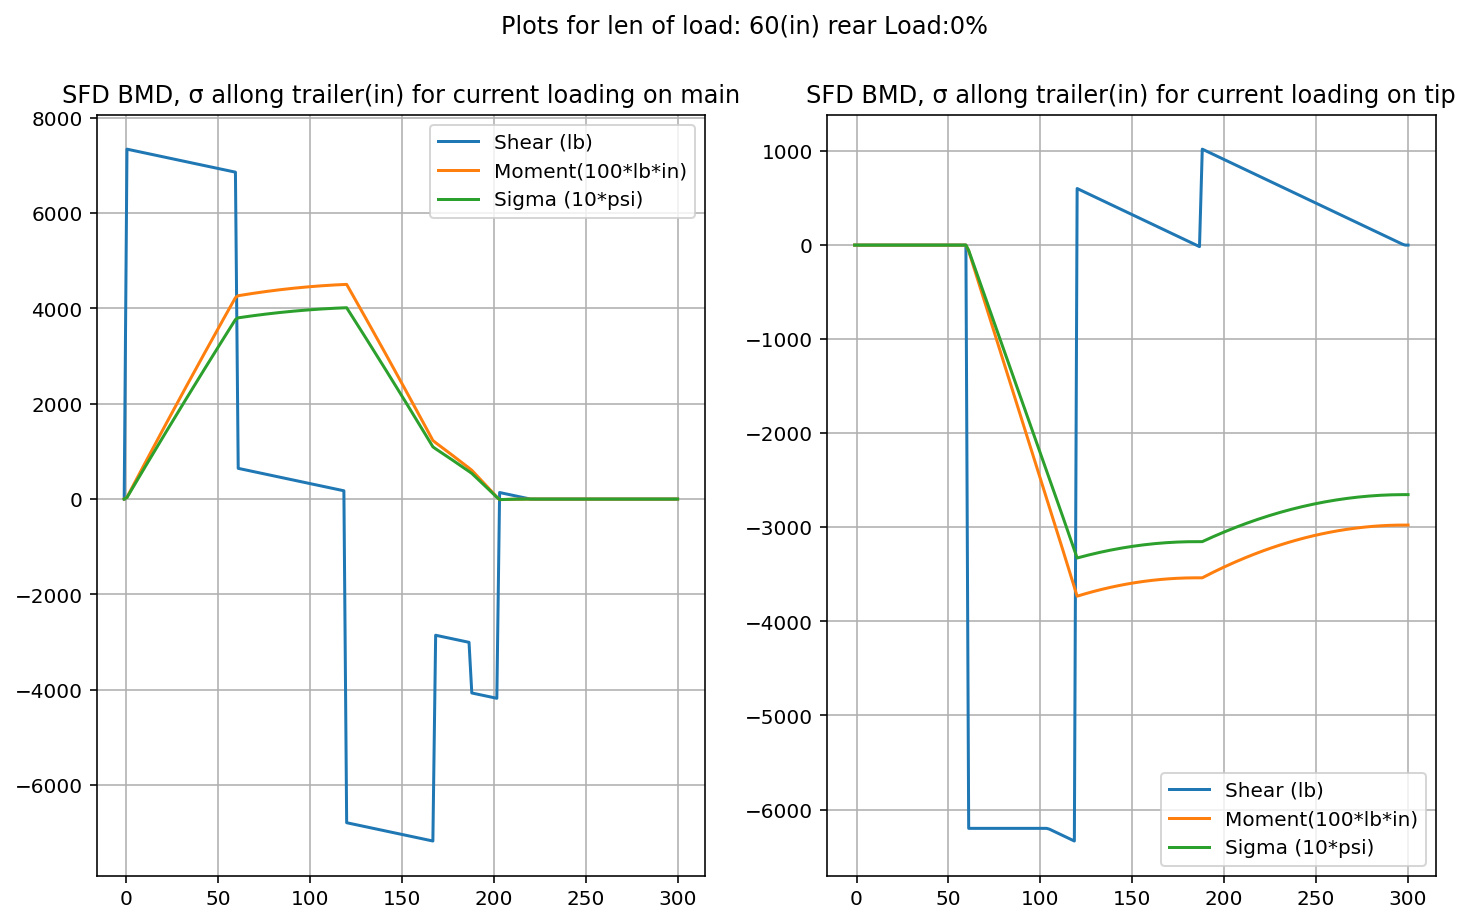

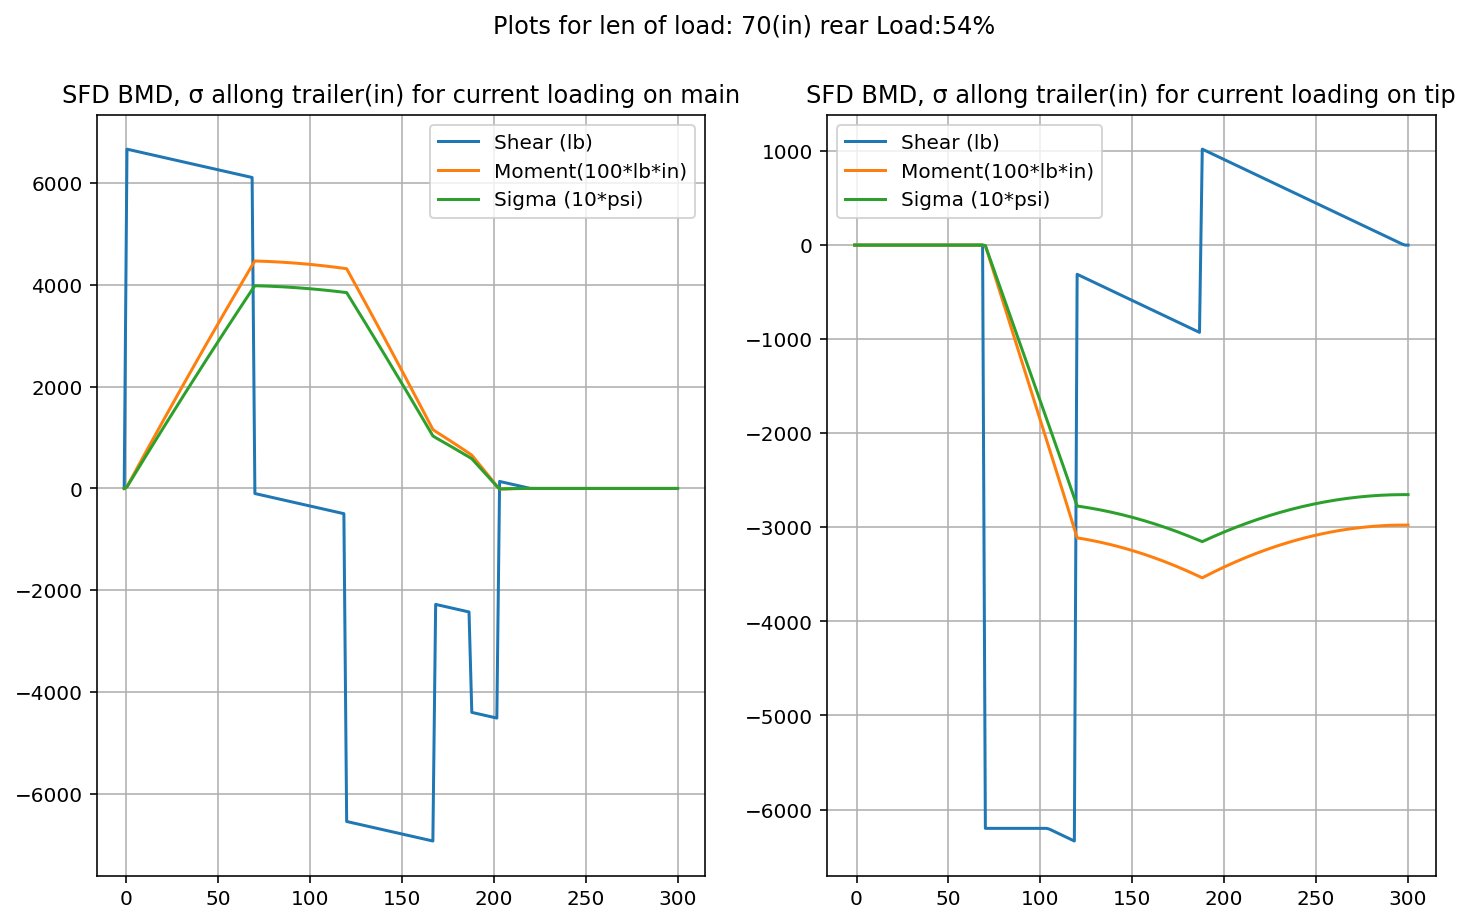

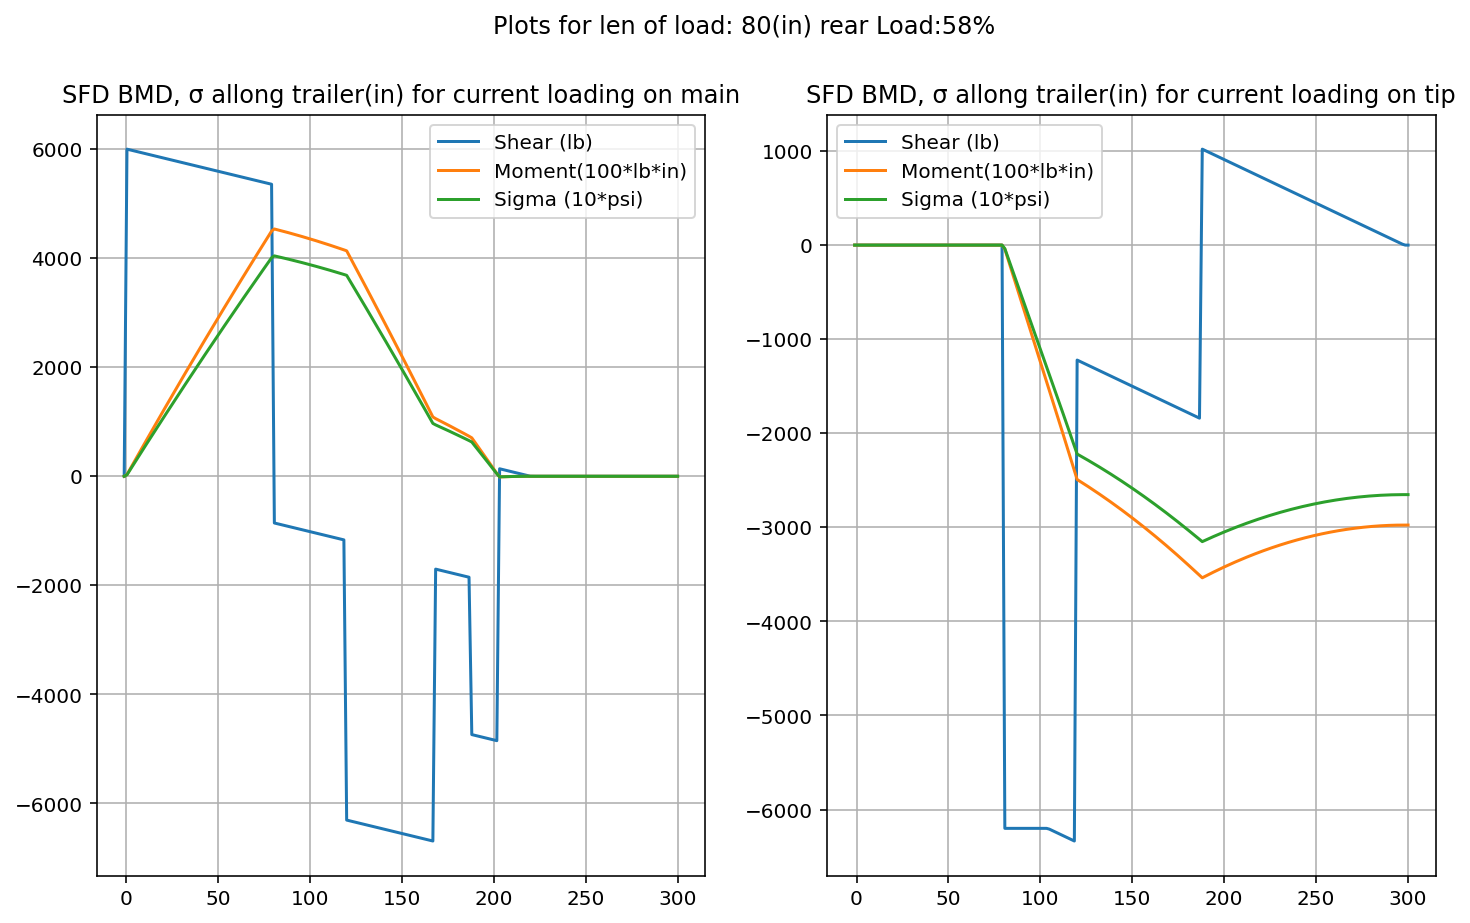

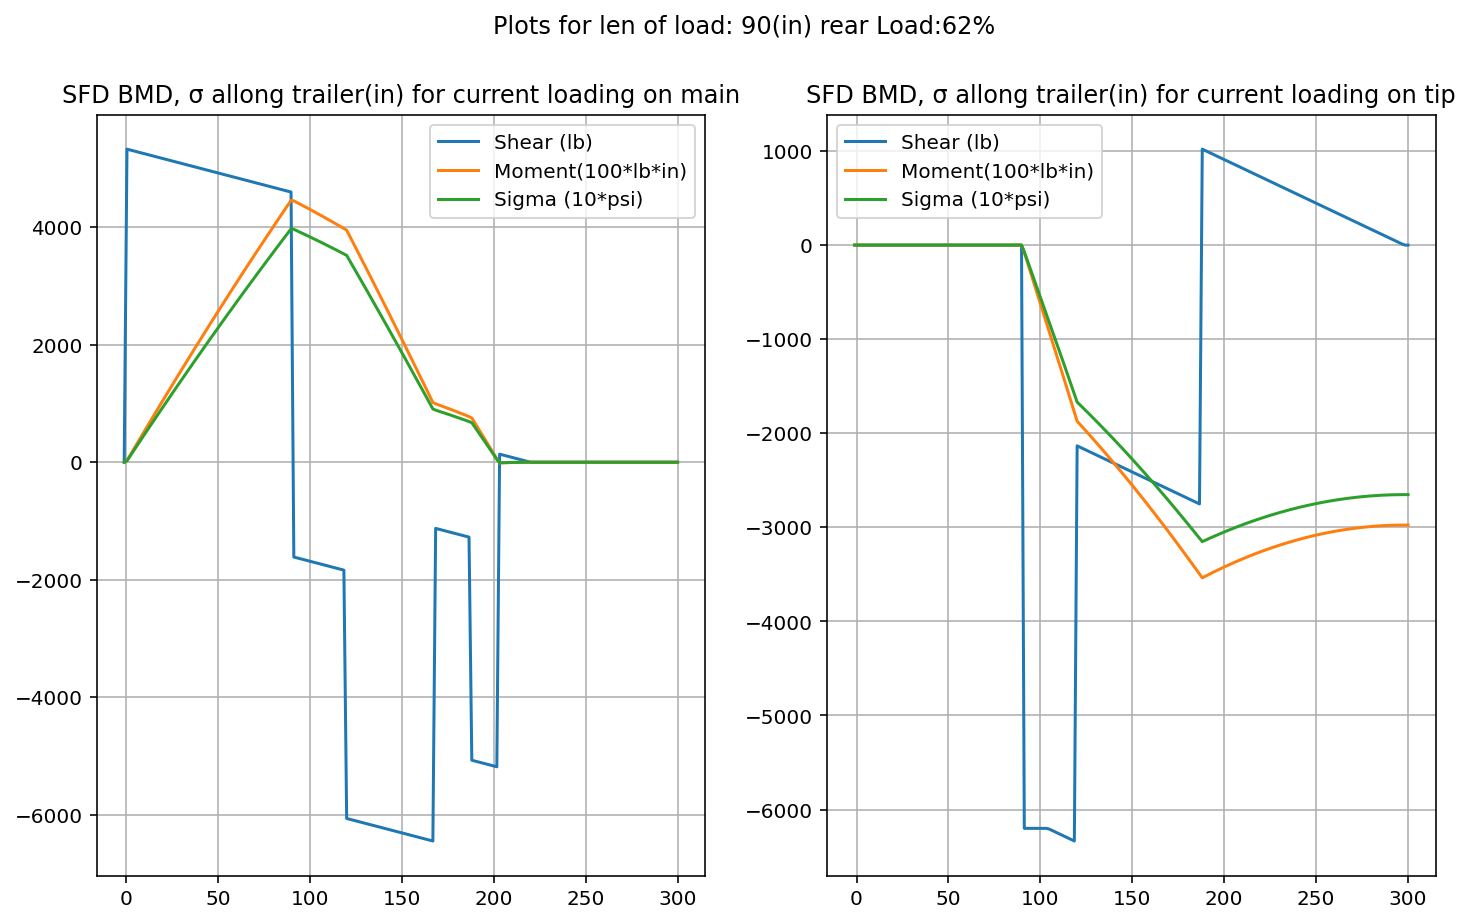

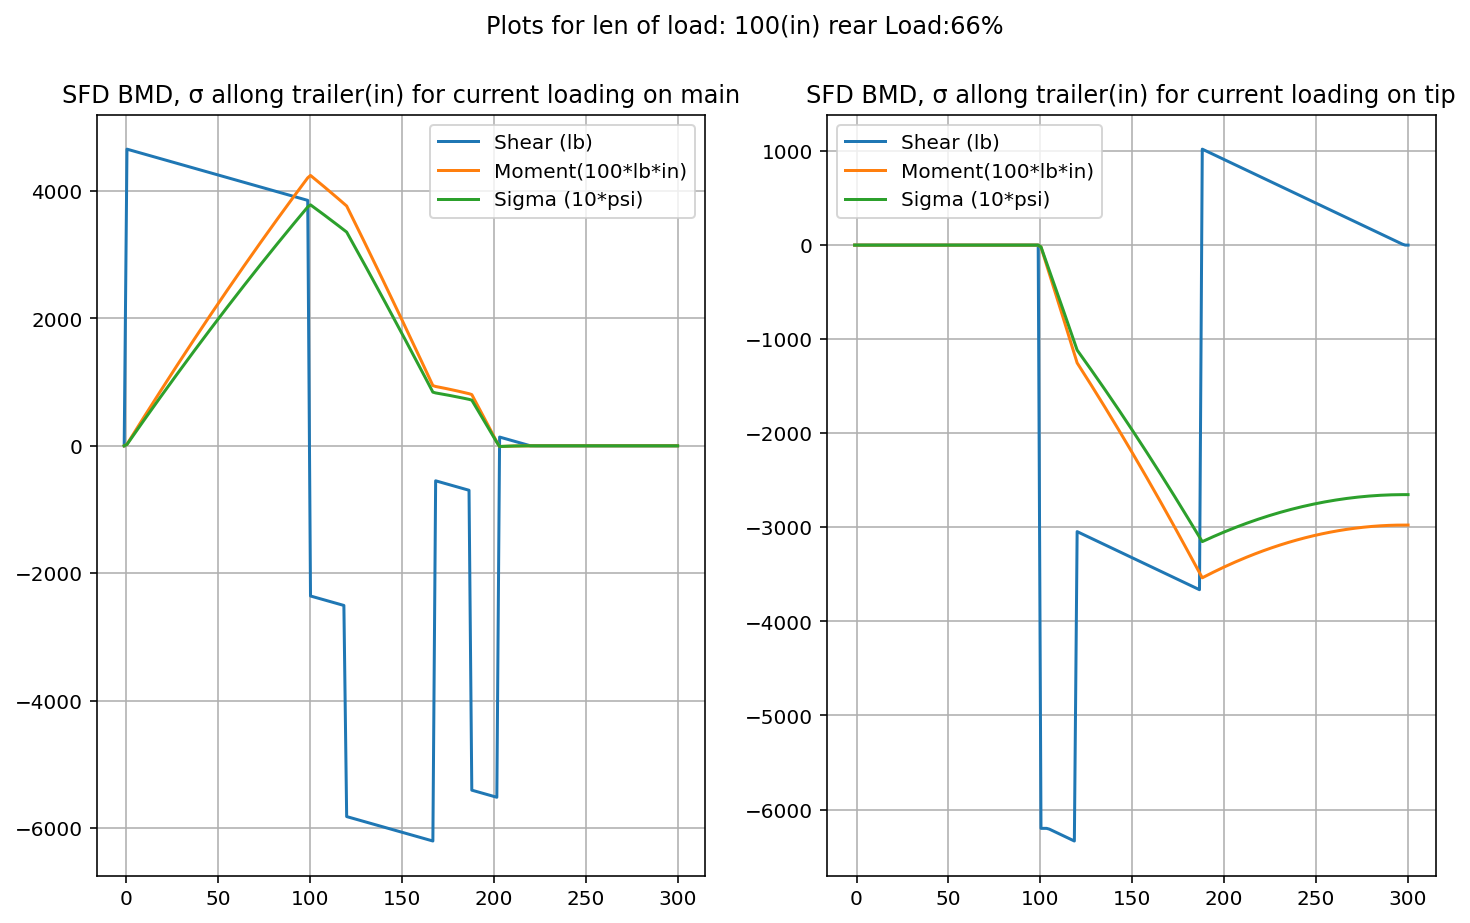

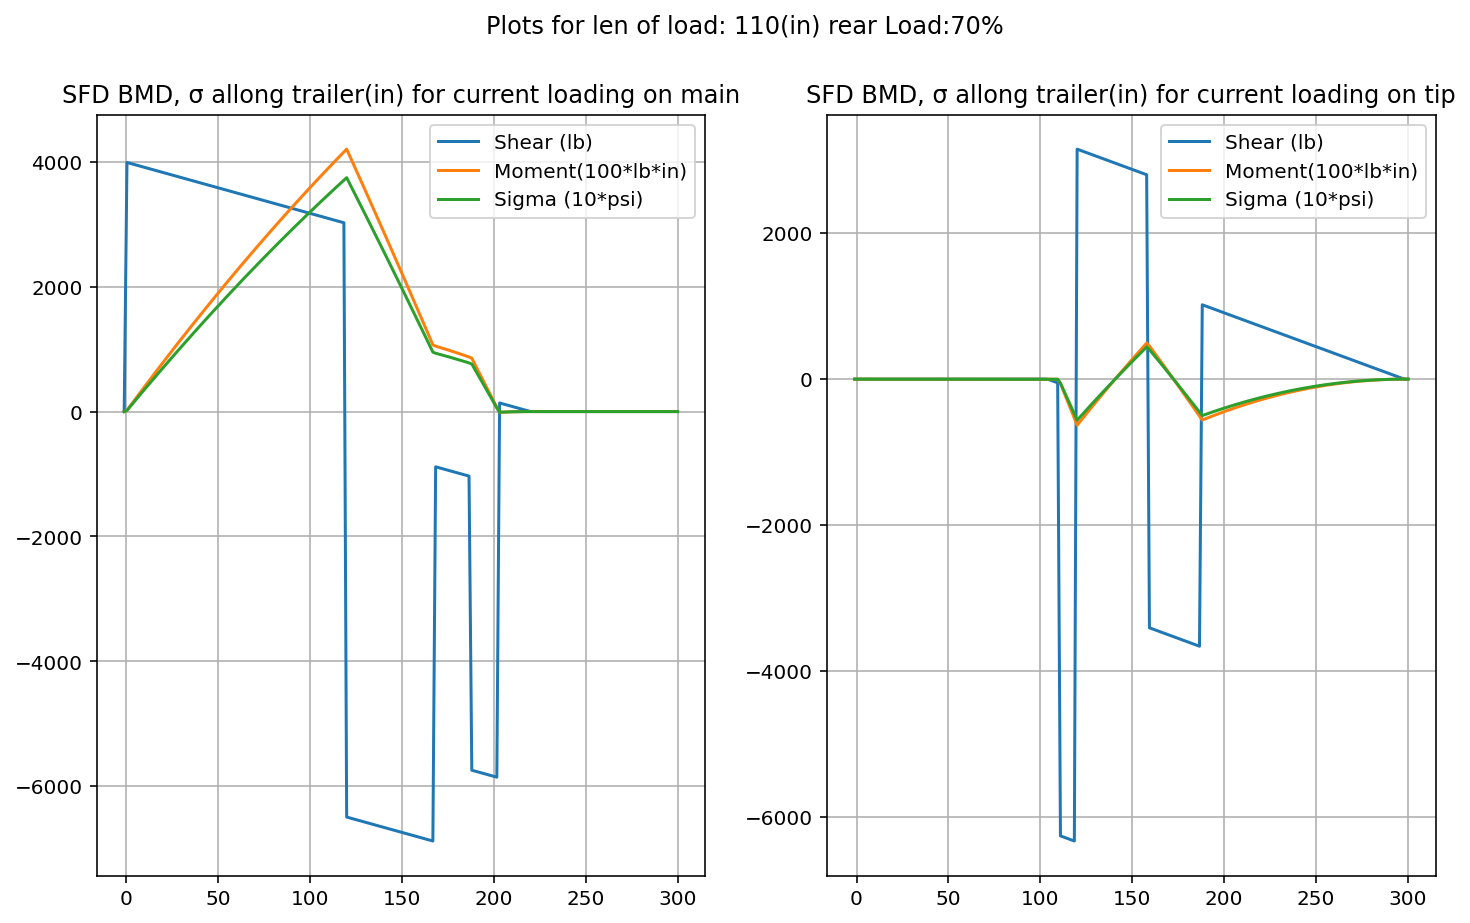

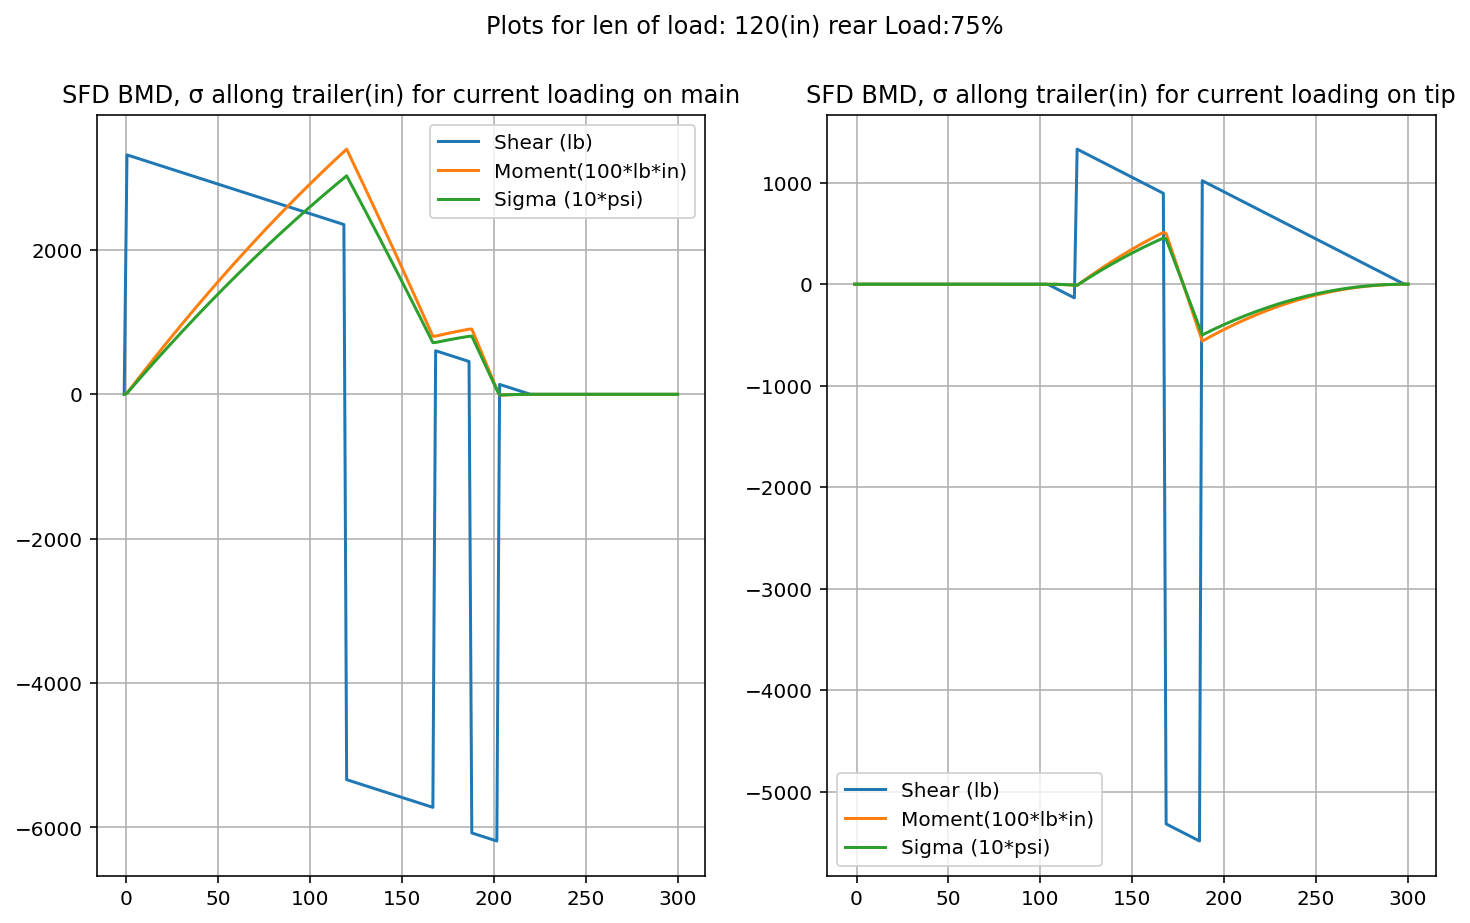

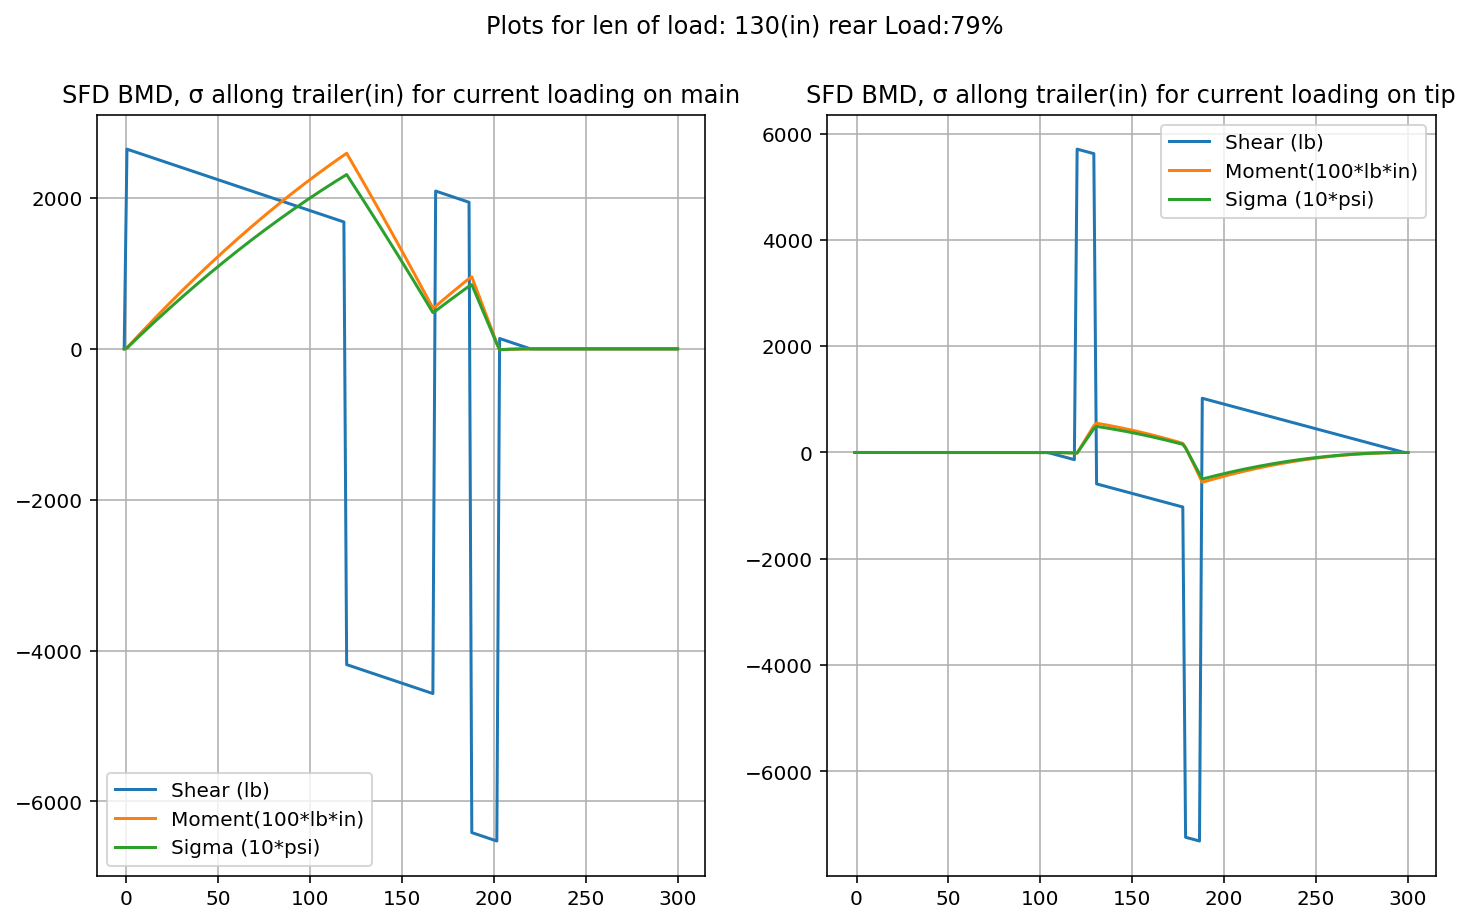

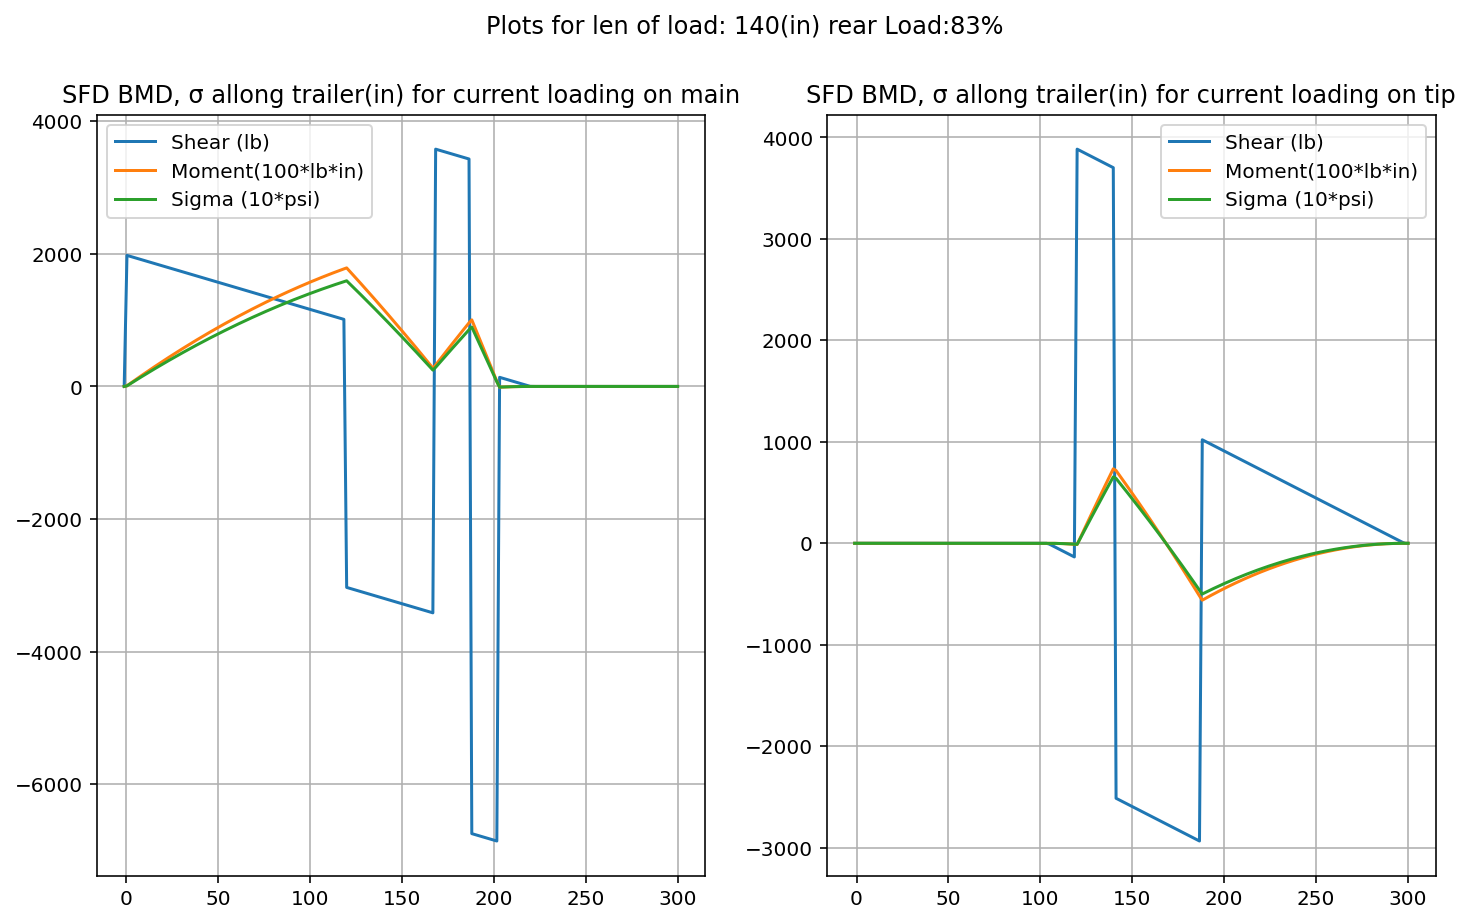

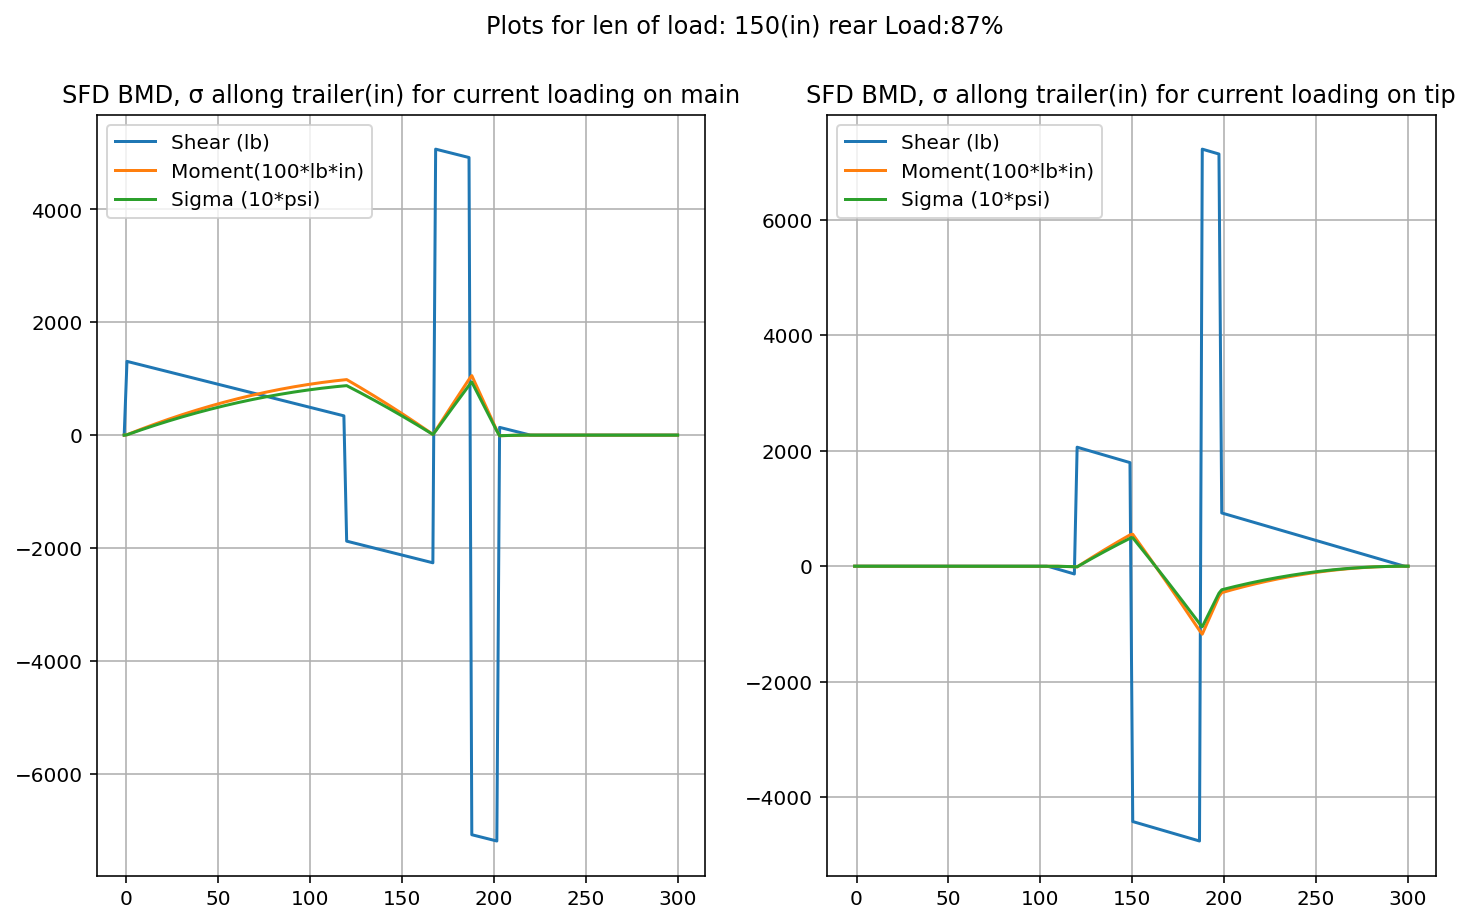

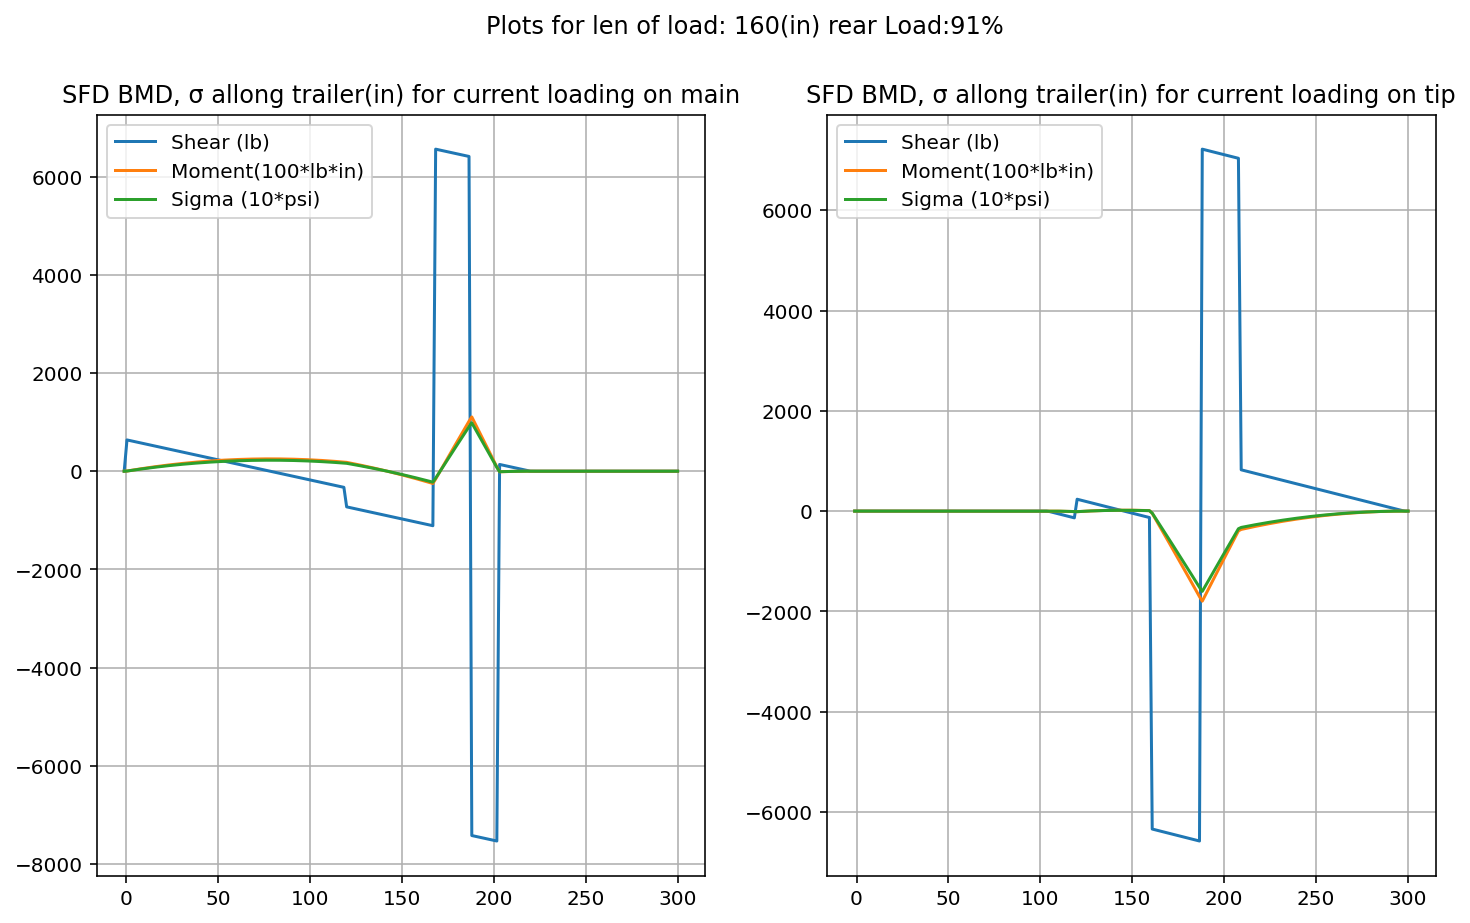

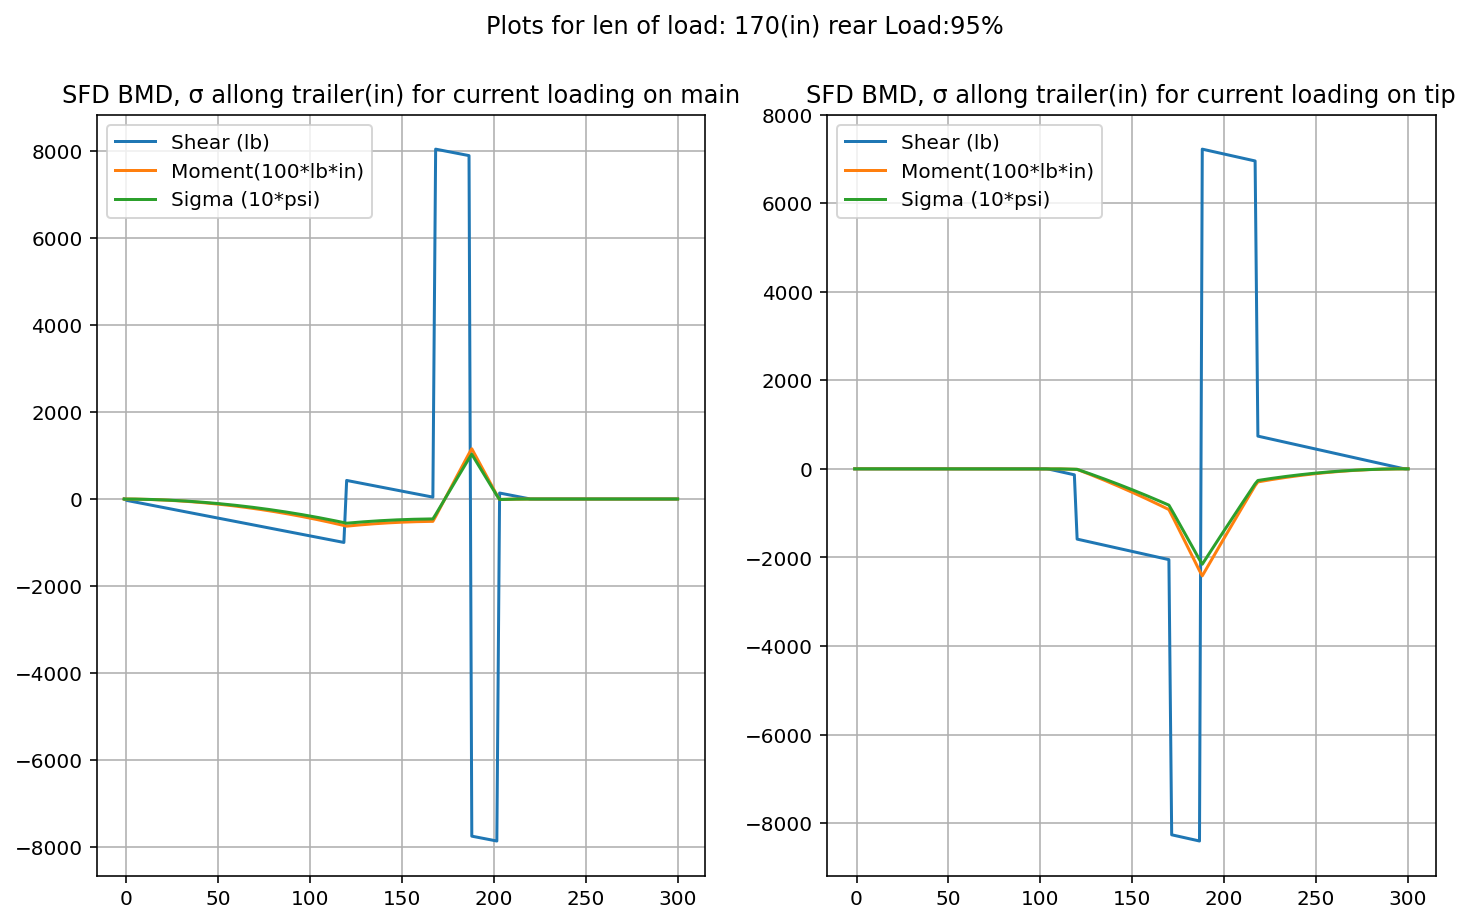

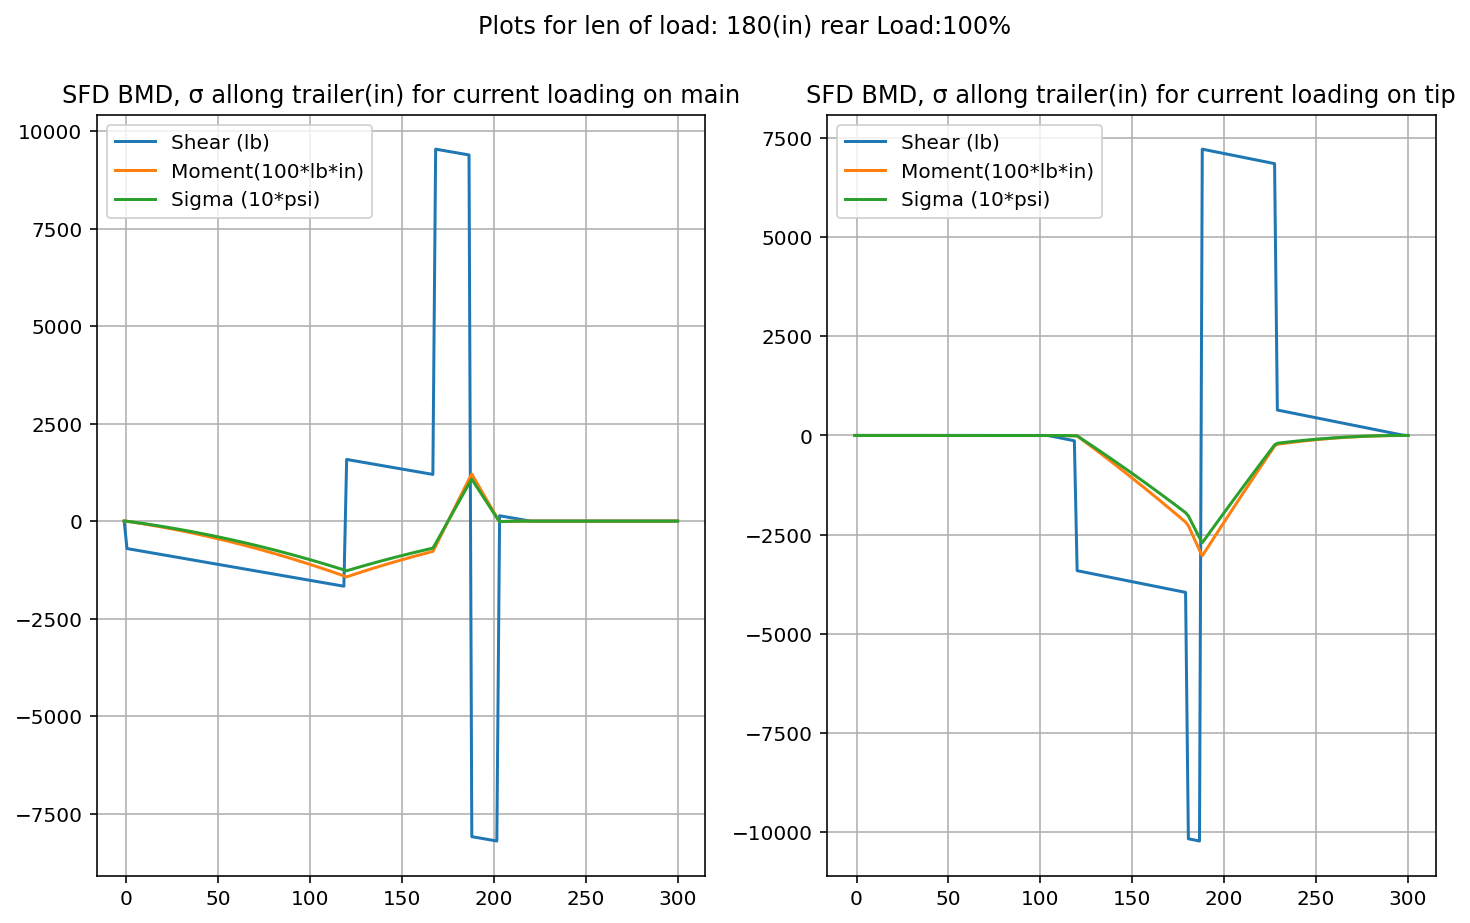

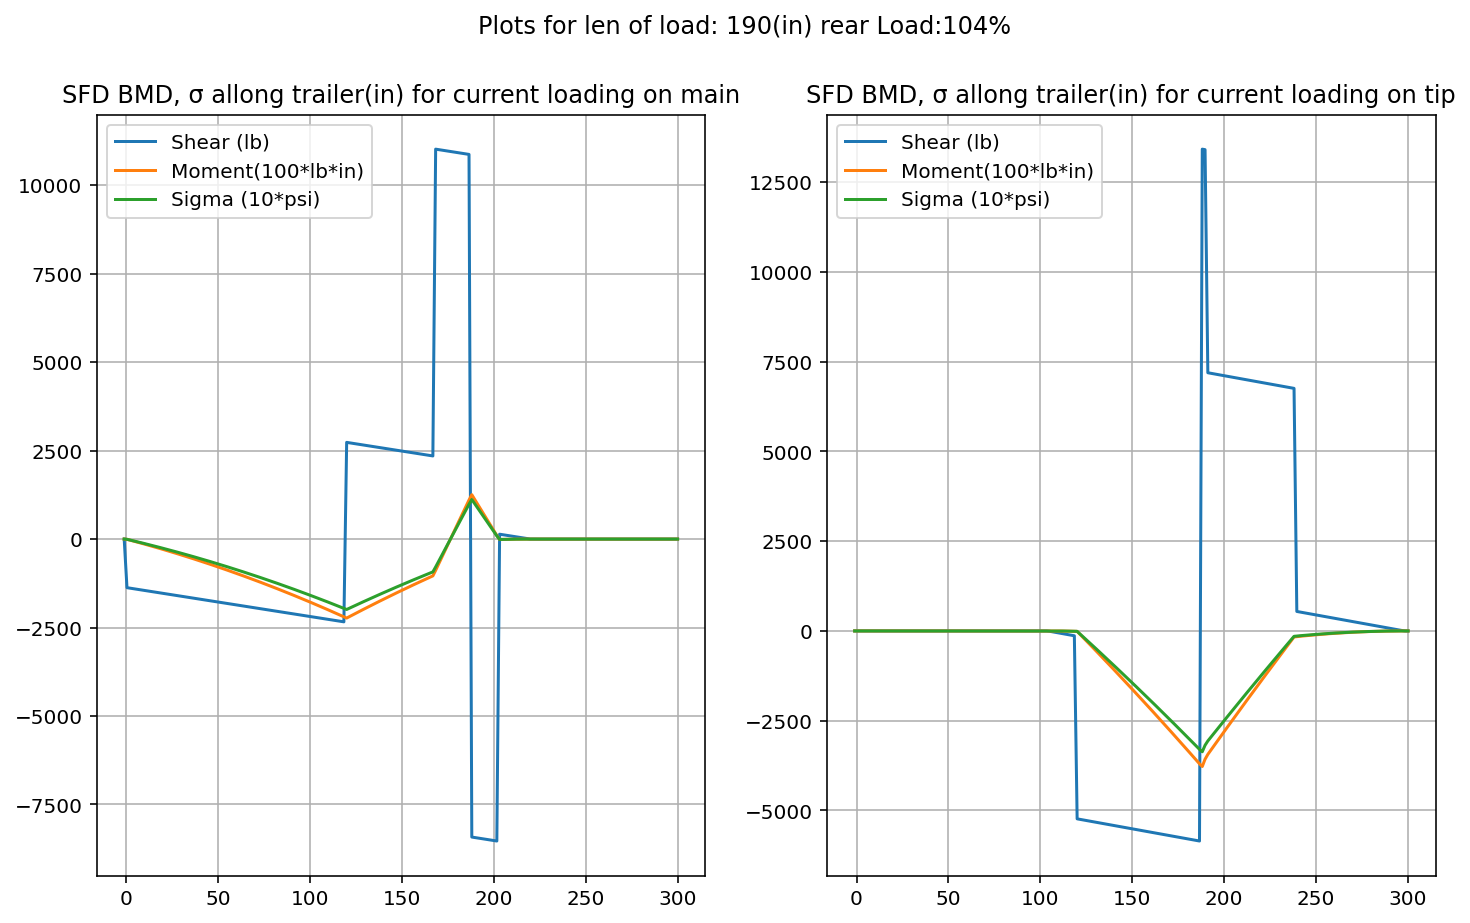

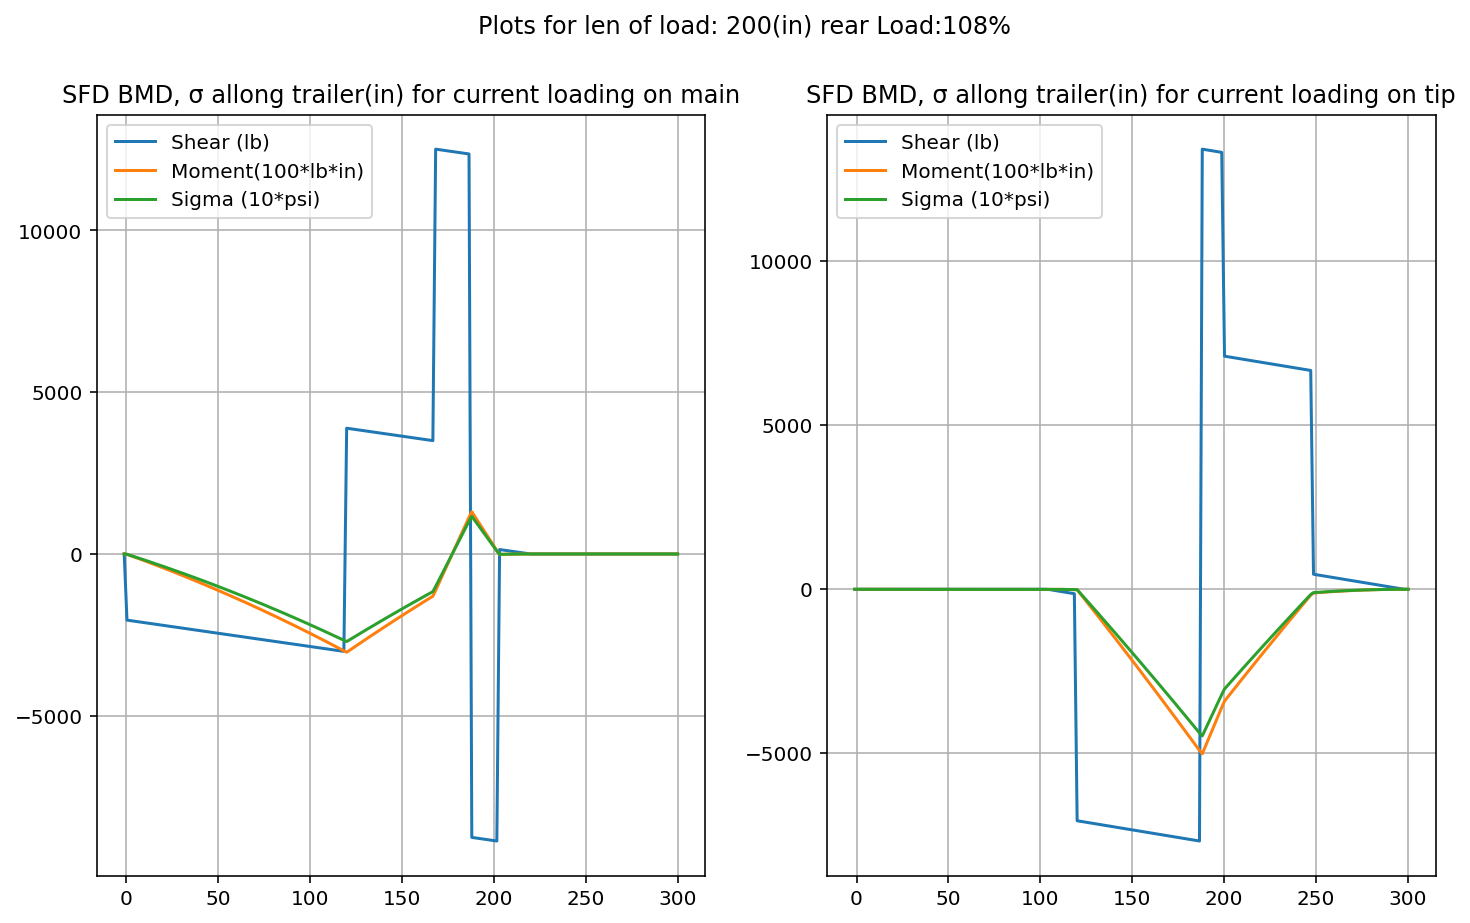

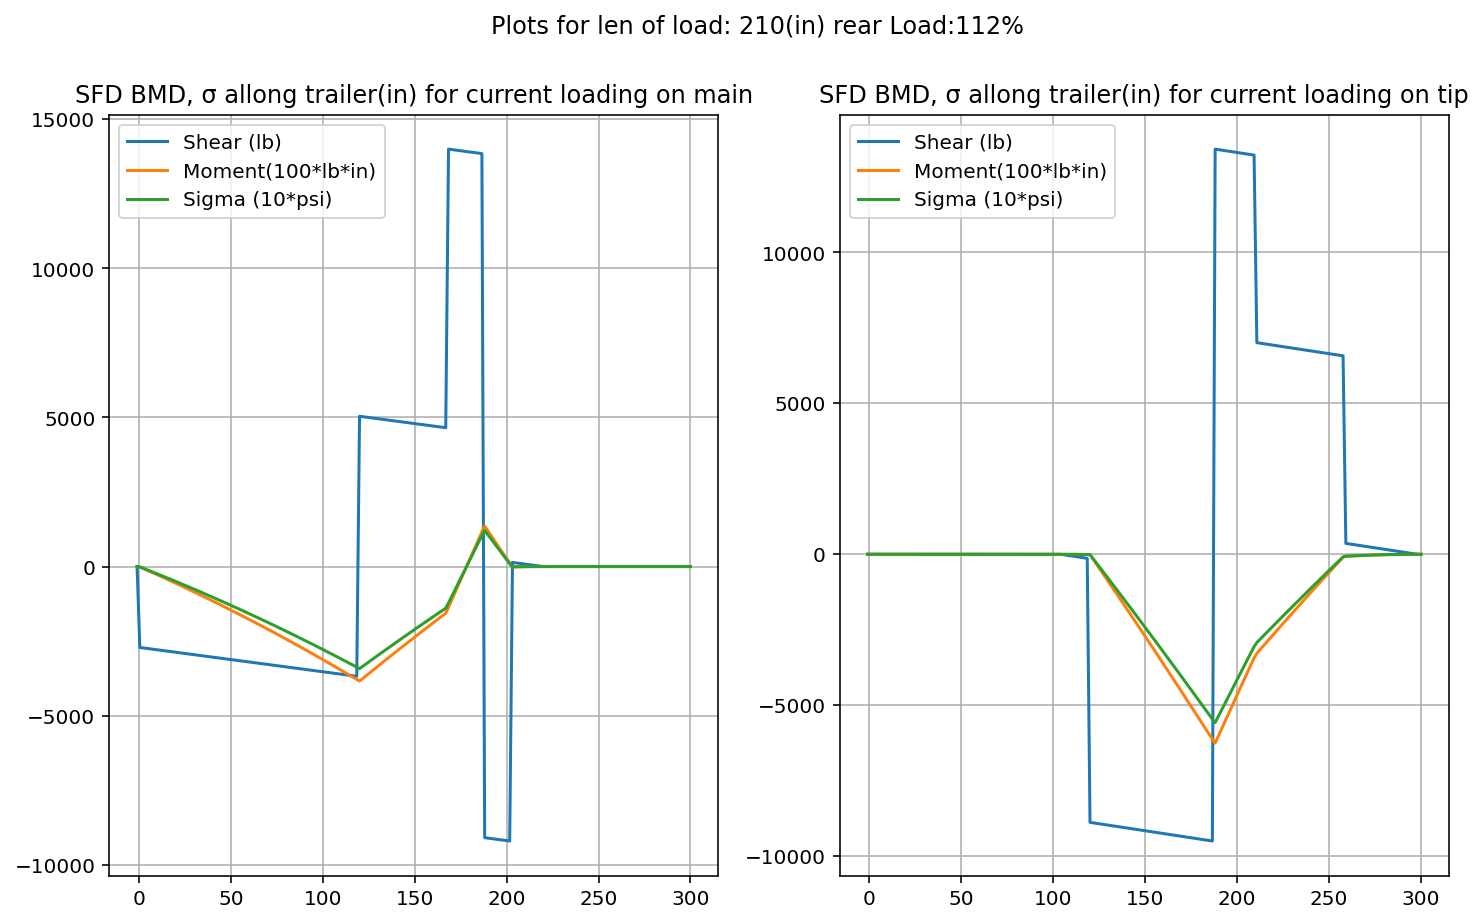

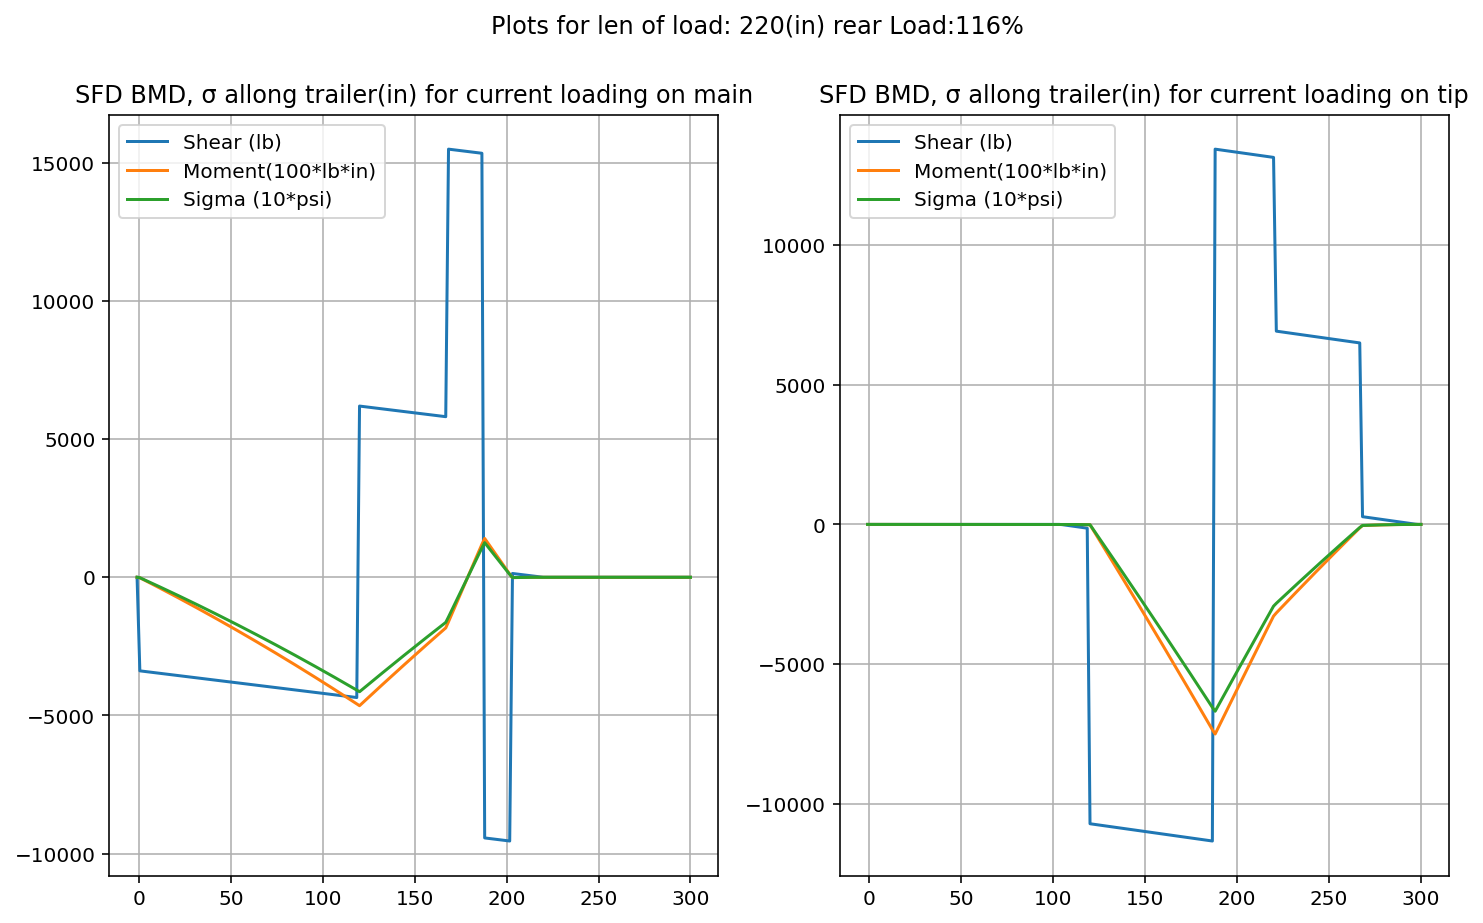

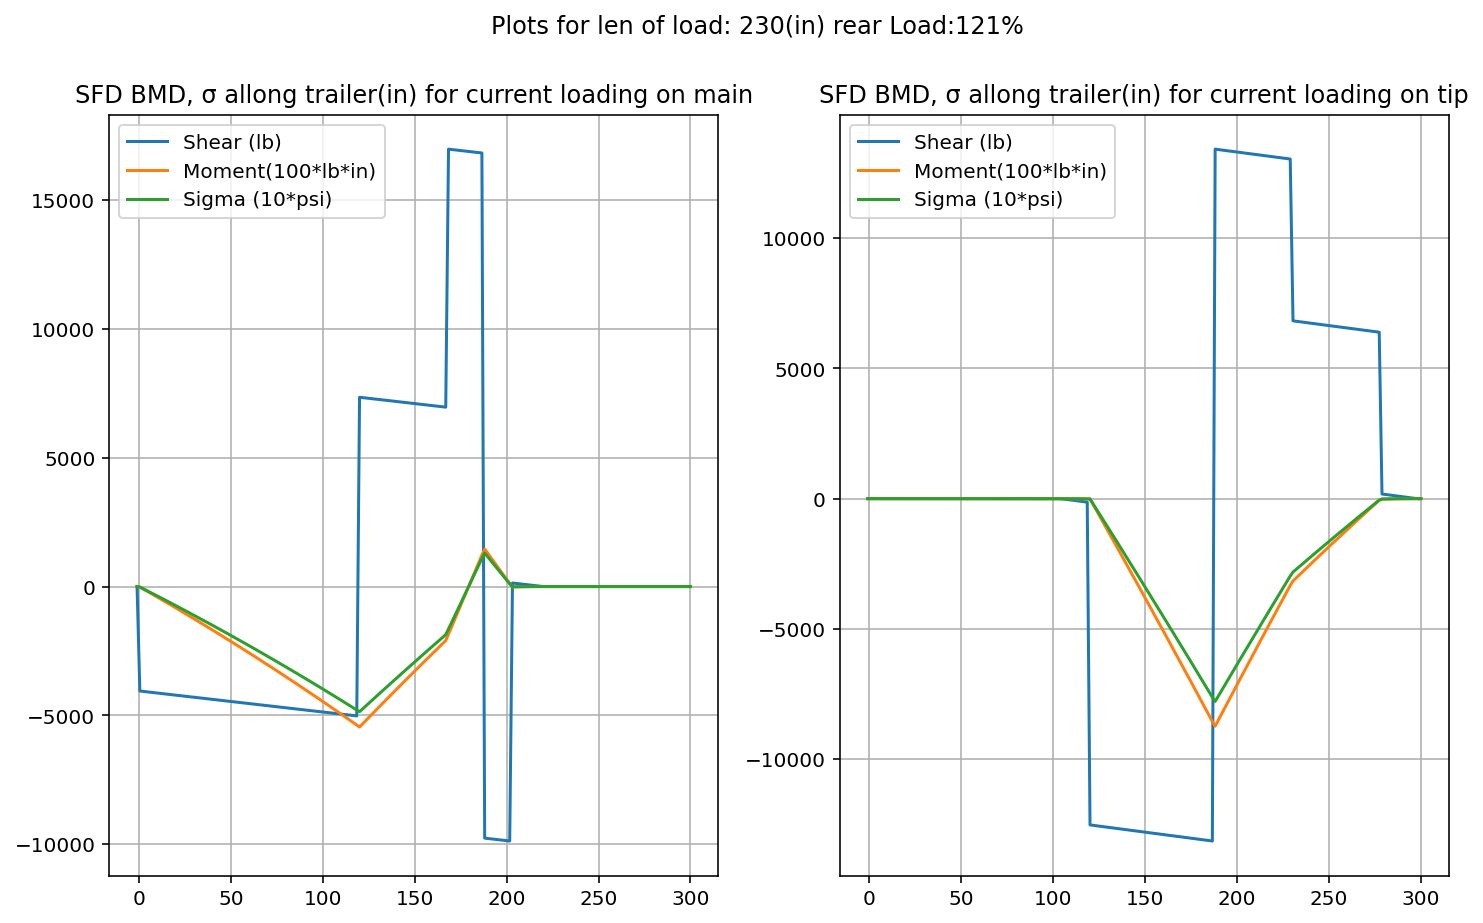

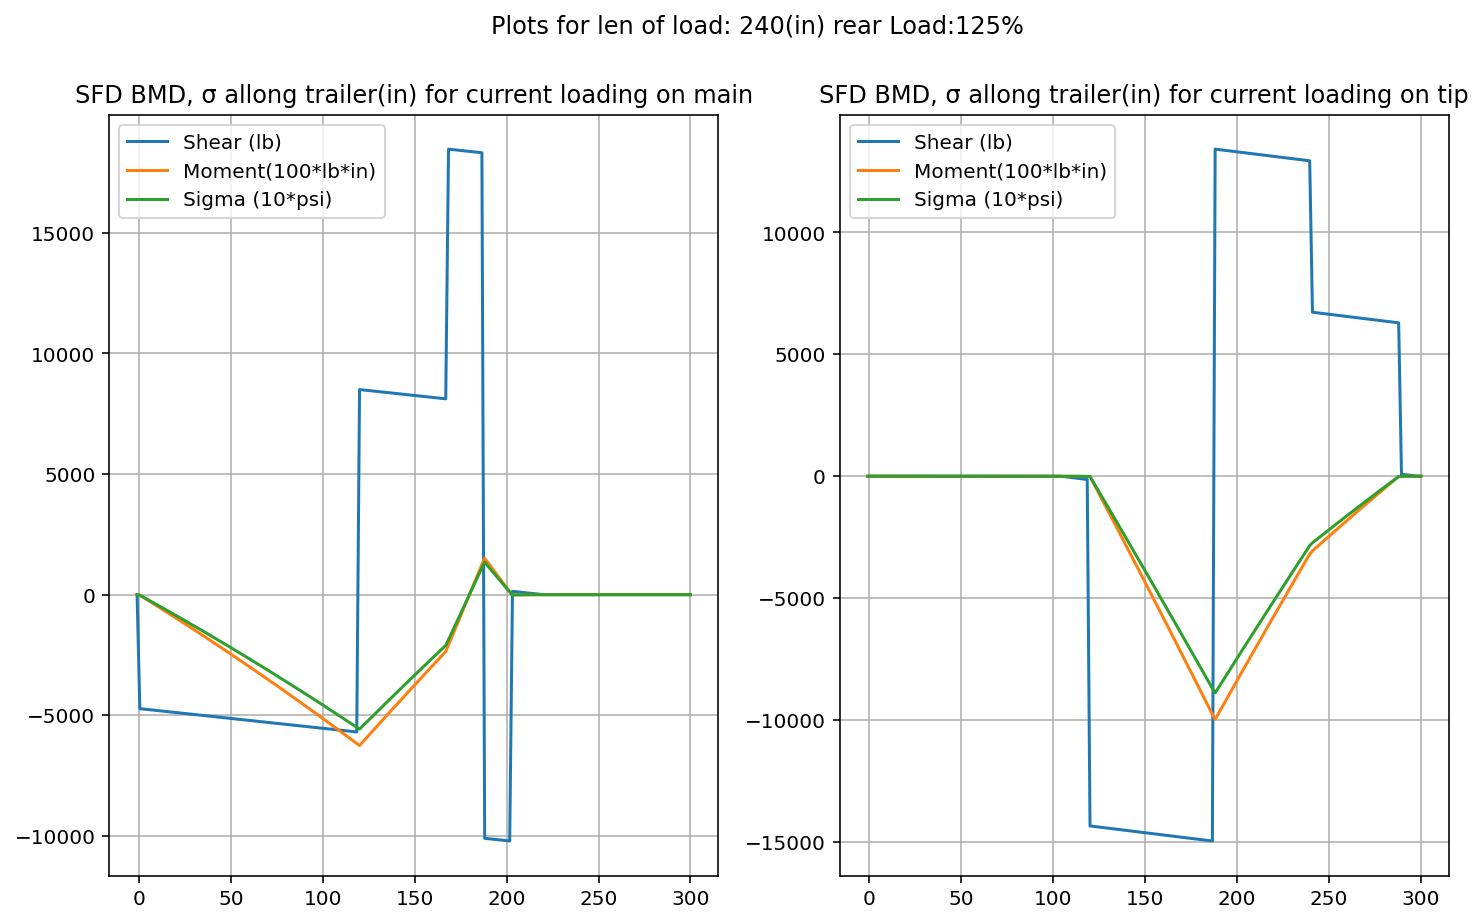

In [5]:
#test 1
#constants
yield_s = 50000
shear_mod = 5.61
shear_mod_tip=5.49

rail_cnt = 2

rail_cnt2 = 2

GVWR = 16000

W_tip = 1800 # tare/2
Rc = GVWR/2 - W_tip

lc = 200-12
a1 = 104


tip_len = 194
base_len = 220

G_base = base_len / 2
G_tip = tip_len / 2 + a1

a2 = a1 + 16
lw1 = lc -21
lw2 = lc +15

wheel_base = 48

react_mat1,react_mattip1,mp,fa = run_f()
plot_x(react_mat1,react_mattip1,mp,fa)


<IPython.core.display.Latex object>

Dis load loc 0.5(in) at rear load: 50% = Max σ: 41742.92(psi)::: 41.7(ksi)

--------------------
overall max at len(in): 0.5, rear load: 50%,  σ = 41742.92(psi)


--------------------
trailer
--------------------

Dis load loc 0.5(in) at rear load: 50% = Max σ: 38670.24(psi)::: 38.7(ksi)

--------------------
overall max at len(in): 0.5, rear load: 50%,  σ = 38670.24(psi)


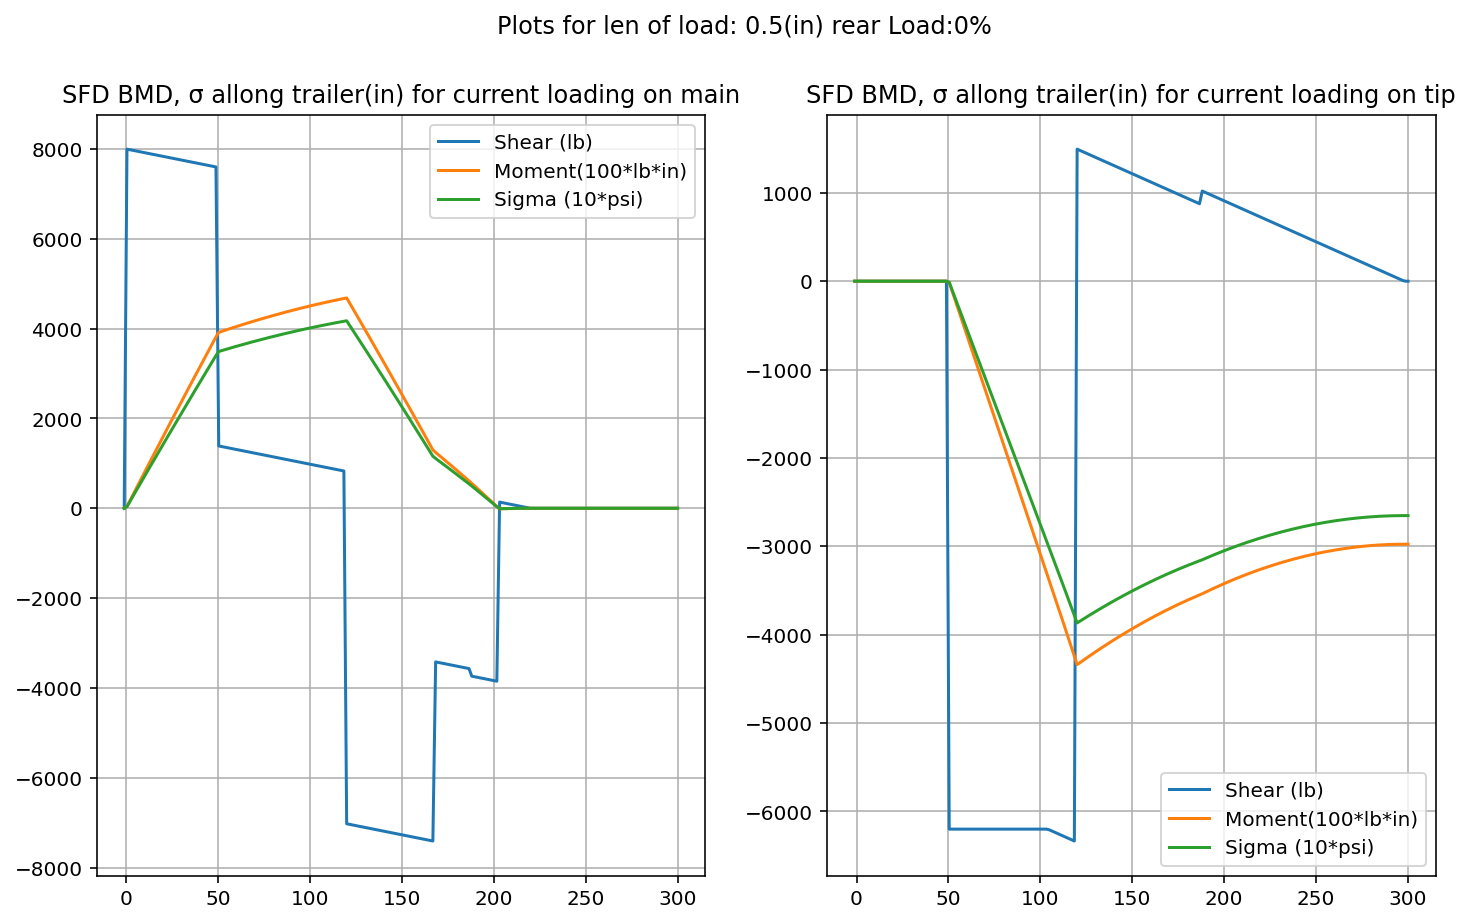

In [6]:
react_mat1,react_mattip1,mp,fa = run_f(0.5)
plot_x(react_mat1,react_mattip1,mp,fa)